## Example Code Step by Step
Step 1: Import Libraries and Download Data

[*********************100%***********************]  1 of 1 completed


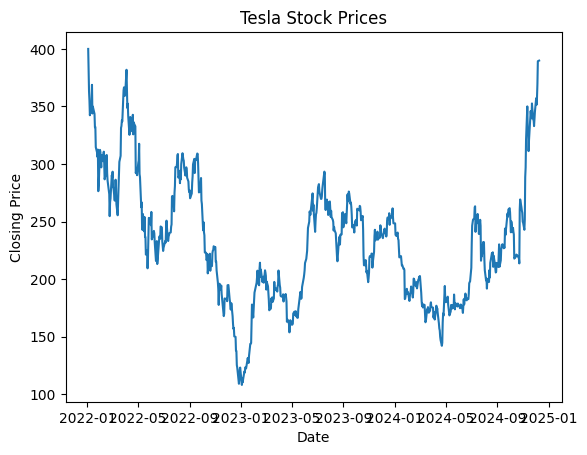

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Download stock data
data = yf.download('TSLA', start='2022-01-01', end='2024-12-10')
data = data[['Close']]
plt.plot(data)
plt.title('Tesla Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

1. pandas (pd): 用於處理和分析資料表格式的數據，像是 DataFrame。
2. numpy (np): 提供高效的數值運算。
3. matplotlib.pyplot (plt): 用於數據視覺化，繪製圖表。
4. yfinance (yf): 用於從 Yahoo Finance 獲取歷史財務數據。


Step 2: Preprocess the Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create time-step data
def create_dataset(data, time_step=10):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, 0])
        Y.append(data[i+time_step, 0])
    return np.array(X), np.array(Y)

X, Y = create_dataset(scaled_data, time_step=10)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

1. `from sklearn.preprocessing import MinMaxScaler`
- This line imports the `MinMaxScaler` from the `sklearn.preprocessing` module.
- `MinMaxScaler` is a tool used to scale the data to a specific range, in this case, between 0 and 1.

2. Normalize the data
- feature_range=(0, 1)：指定縮放後的範圍，這裡是 0 到 1。
- fit_transform(data) 結合了 fit() 和 transform() 兩個操作：fit(data)：計算 data 中每個特徵的最小值和最大值。
transform(data)：根據這些計算出的值，將資料縮放到指定範圍。

3. 建立一個`create_dataset` function
- time_step，將一個一維的時間序列數據轉換為特徵（X）和目標（Y）
- range(len(data) - time_step)：保證能夠提取長度為 time_step 的片段，且不會越界。

4. `X.append(data[i:i+time_step, 0])`
- 從數據中取出從索引 i 到 i+time_step-1 的連續片段。只取第 0 列數據，形成輸入特徵。
- 範例:
若 time_step=3 且 data=[1, 2, 3, 4, 5]，當 i=0 時，提取data[0:3, 0] = [1, 2, 3]。
- 將第 i+time_step 時刻的值作為對應的目標值。
5. `Y.append(data[i+time_step, 0])`
- 將序列中第 `i + time_step` 索引位置的值作為目標值（Y）進行存儲。
- `i+time_step`：確定目標值的位置，對應於當前片段 X 的下一個時間點。
- `data[i+time_step, 0]`：從數據集中選取第 i+time_step 行的第 0 列數據作為目標值。
- `append(...)`：將這個目標值存入列表 Y。
- 範例:
若 time_step=3 且 data=[1, 2, 3, 4, 5]，當 i=0 時，目標值為 data[3, 0] = 4。
6. `return np.array(X), np.array(Y)`
- 將 X 和 Y 轉換為 NumPy 陣列，便於後續機器學習模型的處理。
7. `X, Y = create_dataset(scaled_data, time_step=10)`
- 這行程式碼的作用是調用 create_dataset 函數，將輸入的數據 scaled_data（通常是正規化後的時間序列數據）轉換為適合機器學習模型的輸入特徵（X）和目標值（Y）。

8. 步驟：
- data[i:i+time_step, 0] 提取從第 i 行到第 i+time_step-1 行的數據片段。
- data[i+time_step, 0] 提取第 i+time_step 行的數據作為目標值。
- X 和 Y 最後返回為 NumPy 陣列。

9. `X = X.reshape(X.shape[0], X.shape[1], 1)`  # Reshape for LSTM
- 將 X 的形狀從原來的 (samples, time_steps) 轉換為 (samples, time_steps, features)。
- 為什麼需要重塑？
- LSTM 模型的輸入要求數據形狀為 3D 張量，這裡的 (samples, time_steps, features)：
- samples：每個樣本對應一段時間序列（如 X 的每一行）。
- time_steps：每個樣本包含的時間步數（如 time_step=3）。
- features：每個時間步的特徵數，這裡假設只有一個特徵值（features=1）。
- 不進行重塑的數據形狀（2D）會導致 LSTM 無法正確理解數據結構。

Step 3: Build and Train the LSTM Model

In [ ]:
%%capture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(10, 1))) # 第一層 LSTM
model.add(LSTM(50)) # 第二層 LSTM
model.add(Dense(1)) # 輸出層

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=50, batch_size=32, verbose=1)

1. Sequential:
- 創建一個順序模型，適合層層堆疊的結構。
- 模型的輸入從第一層開始，輸出逐層傳遞，最後到達輸出層。
2. 添加第一層 LSTM
- LSTM(50):
 - 添加一層具有 50 個單元（或神經元）的 LSTM 層。
- return_sequences=True:
 - 指定該層是否返回序列輸出。
 - 如果為 True，則每個時間步都會輸出一個向量，結果形狀為 (samples, time_steps, units)。
 - 此處設為 True 是因為後續還需要堆疊另一層 LSTM。
- input_shape=(10, 1):
 - 定義輸入數據的形狀：
 -  10: 每個樣本的時間步數。
 -  1: 每個時間步的特徵數（單變量時間序列）。
- 只需在模型的第一層指定。

3. 添加第二層 LSTM
- LSTM(50):
 - 再次添加一層具有 50 個單元的 LSTM。
- return_sequences=False（默認值）:
 - 該層只返回最後一個時間步的輸出，結果形狀為 (samples, units)。
 - 因為這是最後一層 LSTM，後續直接接上全連接層，因此不需要返回整個序列。

4. 添加輸出層 (Dense)
- Dense(1):
 - 添加一個具有 1 個神經元的全連接層。
 - 此層生成最終輸出，例如：單步時間序列預測中的下一個值。

5. `model.compile(loss='mean_squared_error', optimizer='adam')`
- 設定模型的 損失函數 和 優化器

6. `model.fit` 的功能
- 是 Keras 中用於訓練模型的主要方法，它將資料傳遞給模型進行多次迭代，並根據指定的損失函數和優化器調整模型的權重。
- 設定為 50 表示模型將重複遍歷數據 50 次。
- epochs=50 表示模型會訓練 50 輪，每一輪模型會完整地遍歷整個數據集一次。
- 定義每次更新權重時所使用的數據量。
 - 如果資料有 320 筆，batch_size=32，模型會將數據分成 10 批次，每次使用 32 筆數據進行計算。
- 控制訓練過程中的輸出顯示。
 - 0：不輸出。
 - 1：顯示進度條（建議用於互動式環境）。
 - 2：每個 epoch 輸出一行簡單摘要。

Step 4: Make Predictions and Visualize Results


In [ ]:
# Predict the stock prices
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)
# Scale back to original prices

# Visualize predictions
plt.plot(data.index[10:], predictions, label='Predicted Price')
plt.plot(data, label='Actual Price')
plt.legend()
plt.title('Tesla Stock Price Prediction')
plt.show()

1.  `predictions = model.predict(X)`

-  `model.predict(X)` 利用訓練好的 LSTM 模型，針對每筆輸入數據進行預測。
-  LSTM 模型會根據過去的資料，預測下一個時間點的目標值（例如，下一天的股票價格）。

2. `predictions = scaler.inverse_transform(predictions)`

- 將模型預測結果從正規化後的範圍（例如 [0, 1]）還原到原始數據的範圍。